* Create a graph

In [1]:
from graphframes import GraphFrame
# Vertex DataFrame
v = spark.createDataFrame([
 ("a", "Alice", 34),
 ("b", "Bob", 36),
 ("c", "Charlie", 30),
 ("d", "David", 29),
 ("e", "Esther", 32),
 ("f", "Fanny", 36),
 ("g", "Gabby", 60)
], ["id", "name", "age"])
# Edge DataFrame
e = spark.createDataFrame([
 ("a", "b", "friend"),
 ("b", "c", "follow"),
 ("c", "b", "follow"),
 ("f", "c", "follow"),
 ("e", "f", "follow"),
 ("e", "d", "friend"),
 ("d", "a", "friend"),
 ("a", "e", "friend"),
 ("q", "w", "friend"),
 ("y", "z", "friend")
], ["src", "dst", "relationship"])
# Create a GraphFrame
g = GraphFrame(v, e)


In [2]:
g.vertices.show()
g.edges.show()


+---+-------+---+
| id|   name|age|
+---+-------+---+
|  a|  Alice| 34|
|  b|    Bob| 36|
|  c|Charlie| 30|
|  d|  David| 29|
|  e| Esther| 32|
|  f|  Fanny| 36|
|  g|  Gabby| 60|
+---+-------+---+

+---+---+------------+
|src|dst|relationship|
+---+---+------------+
|  a|  b|      friend|
|  b|  c|      follow|
|  c|  b|      follow|
|  f|  c|      follow|
|  e|  f|      follow|
|  e|  d|      friend|
|  d|  a|      friend|
|  a|  e|      friend|
|  q|  w|      friend|
|  y|  z|      friend|
+---+---+------------+



* Motif finding

In [10]:
# find all the users that follow each other
motifs = g.find("(a)-[e]->(b);(b)-[e2]->(a)")
motifs.show()
motifs.select("a").show()

+----------------+--------------+----------------+--------------+
|               a|             e|               b|            e2|
+----------------+--------------+----------------+--------------+
|[c, Charlie, 30]|[c, b, follow]|    [b, Bob, 36]|[b, c, follow]|
|    [b, Bob, 36]|[b, c, follow]|[c, Charlie, 30]|[c, b, follow]|
+----------------+--------------+----------------+--------------+

+----------------+
|               a|
+----------------+
|[c, Charlie, 30]|
|    [b, Bob, 36]|
+----------------+



In [11]:
#Identify chains of 4 users/vertices such that at least 2 of the 3 edges are “friend” relationships. 
from pyspark.sql.types import BooleanType
from pyspark.sql.functions import udf
chain4 = g.find("(a)-[ab]->(b); (b)-[bc]->(c); (c)-[cd]->(d)")
def condition(ab,bc,cd):
    first=(ab["relationship"]== "friend")
    second=(bc["relationship"]== "friend")
    third=(cd["relationship"]== "friend")
    return (int(first)+int(second)+int(third)>=2)

conditionUDF = udf(condition,BooleanType())
chainWith2Friends = chain4.filter(conditionUDF(chain4.ab,chain4.bc,chain4.cd))
chainWith2Friends.show()

+---------------+--------------+---------------+--------------+---------------+--------------+----------------+
|              a|            ab|              b|            bc|              c|            cd|               d|
+---------------+--------------+---------------+--------------+---------------+--------------+----------------+
| [d, David, 29]|[d, a, friend]| [a, Alice, 34]|[a, e, friend]|[e, Esther, 32]|[e, f, follow]|  [f, Fanny, 36]|
|[e, Esther, 32]|[e, d, friend]| [d, David, 29]|[d, a, friend]| [a, Alice, 34]|[a, e, friend]| [e, Esther, 32]|
| [d, David, 29]|[d, a, friend]| [a, Alice, 34]|[a, e, friend]|[e, Esther, 32]|[e, d, friend]|  [d, David, 29]|
| [d, David, 29]|[d, a, friend]| [a, Alice, 34]|[a, b, friend]|   [b, Bob, 36]|[b, c, follow]|[c, Charlie, 30]|
|[e, Esther, 32]|[e, d, friend]| [d, David, 29]|[d, a, friend]| [a, Alice, 34]|[a, b, friend]|    [b, Bob, 36]|
| [a, Alice, 34]|[a, e, friend]|[e, Esther, 32]|[e, d, friend]| [d, David, 29]|[d, a, friend]|  [a, Alic

* Subgraphs

In [13]:
# Option 1 filterVertices,filterEdges,DropIsolatedVertices
g1 = g.filterVertices("age>30")
g2 = g1.filterEdges("relationship='friend'")
g3 = g2.dropIsolatedVertices()
g3.edges.show()
g3.vertices.show()
# Option 2 Process edges/nodes adn recreate a now graph
#(Select subgraph based on edges "e" of type "follow" pointing from a younger user "a" to an older user "b")
paths = g.find("(a)-[e]->(b)")\
 .filter("e.relationship = 'follow'")\
 .filter("a.age < b.age")
e4 = paths.select("e.src", "e.dst", "e.relationship")
g4 = GraphFrame(g.vertices, e4).dropIsolatedVertices()
g4.edges.show()
g4.vertices.show()

+---+---+------------+
|src|dst|relationship|
+---+---+------------+
|  a|  e|      friend|
|  a|  b|      friend|
+---+---+------------+

+---+------+---+
| id|  name|age|
+---+------+---+
|  e|Esther| 32|
|  b|   Bob| 36|
|  a| Alice| 34|
+---+------+---+

+---+---+------------+
|src|dst|relationship|
+---+---+------------+
|  e|  f|      follow|
|  c|  b|      follow|
+---+---+------------+

+---+-------+---+
| id|   name|age|
+---+-------+---+
|  f|  Fanny| 36|
|  e| Esther| 32|
|  c|Charlie| 30|
|  b|    Bob| 36|
+---+-------+---+



* Degrees

In [16]:
gDeg = g.degrees
gDegSorted = gDeg.sort("degree",ascending=False)
gDegSorted.show()

gOut=g.outDegrees
gOut.filter("outDegree>0").show()

gIn = g.inDegrees
gIn.filter("InDegree>0").show()

+---+------+
| id|degree|
+---+------+
|  b|     3|
|  c|     3|
|  e|     3|
|  a|     3|
|  f|     2|
|  d|     2|
+---+------+

+---+---------+
| id|outDegree|
+---+---------+
|  f|        1|
|  e|        2|
|  d|        1|
|  c|        1|
|  b|        1|
|  a|        2|
+---+---------+

+---+--------+
| id|inDegree|
+---+--------+
|  f|       1|
|  e|       1|
|  d|       1|
|  c|       2|
|  b|       2|
|  a|       1|
+---+--------+



* Checkpoint directory

In [ ]:
sc.setCheckpointDir('graphframes_ckpts_dir')

* Breadth First Search (BFS)
    --finds the shortest paths from one vertex to another vertex

In [18]:
#Search shortest path from "Esther" to "Charlie"
paths = g.bfs(fromExpr="id = 'e'", toExpr="id = 'c'")
paths.show()

# Find the shortest path from Esther to users of age more than 34, without using edges of type “follow”
paths2=g.bfs("name = 'Esther'", "age > 34",edgeFilter="relationship != 'follow'")
paths2.show()

+---------------+--------------+--------------+--------------+----------------+
|           from|            e0|            v1|            e1|              to|
+---------------+--------------+--------------+--------------+----------------+
|[e, Esther, 32]|[e, f, follow]|[f, Fanny, 36]|[f, c, follow]|[c, Charlie, 30]|
+---------------+--------------+--------------+--------------+----------------+

+---------------+--------------+--------------+--------------+--------------+--------------+------------+
|           from|            e0|            v1|            e1|            v2|            e2|          to|
+---------------+--------------+--------------+--------------+--------------+--------------+------------+
|[e, Esther, 32]|[e, d, friend]|[d, David, 29]|[d, a, friend]|[a, Alice, 34]|[a, b, friend]|[b, Bob, 36]|
+---------------+--------------+--------------+--------------+--------------+--------------+------------+



* Shortest paths --computes length of shortest paths from each vertex to a given set of landmark vertices

In [19]:
landmarks=["a", "d"]
results = g.shortestPaths(landmarks=landmarks)
results.show()

+---+-------+---+----------------+
| id|   name|age|       distances|
+---+-------+---+----------------+
|  g|  Gabby| 60|              []|
|  b|    Bob| 36|              []|
|  e| Esther| 32|[d -> 1, a -> 2]|
|  a|  Alice| 34|[a -> 0, d -> 2]|
|  f|  Fanny| 36|              []|
|  d|  David| 29|[d -> 0, a -> 1]|
|  c|Charlie| 30|              []|
+---+-------+---+----------------+



* Connected components --need to set checkpoint directory

In [20]:
sc.setCheckpointDir("tmp_ckpts")
connComp=g.connectedComponents()
#show results. Order by component in order to have nodes of the same component in adjacent rows
connComp.orderBy("component").show()

nComp=connComp.select("component").distinct().count()
print("Number of connected components: ", nComp)

+---+-------+---+------------+
| id|   name|age|   component|
+---+-------+---+------------+
|  g|  Gabby| 60|146028888064|
|  a|  Alice| 34|412316860416|
|  b|    Bob| 36|412316860416|
|  c|Charlie| 30|412316860416|
|  d|  David| 29|412316860416|
|  f|  Fanny| 36|412316860416|
|  e| Esther| 32|412316860416|
+---+-------+---+------------+

Number of connected components:  2


* Strongly connected componenets

In [21]:
sc.setCheckpointDir("tmp_ckpts")
strongConnComp = g.stronglyConnectedComponents(maxIter=10)
strongConnComp.orderBy("component").show()
nComp=strongConnComp.select("component").distinct().count()
print("Number of strongly connected components: ", nComp)

+---+-------+---+-------------+
| id|   name|age|    component|
+---+-------+---+-------------+
|  g|  Gabby| 60| 146028888064|
|  f|  Fanny| 36| 412316860416|
|  e| Esther| 32| 670014898176|
|  d|  David| 29| 670014898176|
|  a|  Alice| 34| 670014898176|
|  b|    Bob| 36|1047972020224|
|  c|Charlie| 30|1047972020224|
+---+-------+---+-------------+

Number of strongly connected components:  4


* Label propagation --for detecting communities in graphs

In [22]:
result = g.labelPropagation(maxIter=20)
result.select("id", "label").orderBy("label").show()

+---+-------------+
| id|        label|
+---+-------------+
|  g| 146028888064|
|  a| 412316860416|
|  d| 412316860416|
|  e| 670014898176|
|  c|1047972020224|
|  b|1382979469312|
|  f|1382979469312|
+---+-------------+



* PageRank

In [23]:
# Run PageRank until convergence to tolerance "tol".
results = g.pageRank(tol=0.03)
# Display resulting pageranks
results.vertices.show(truncate=False)
# Run PersonalizedPageRank until convergence to tolerance "tol".
resultsPers = g.pageRank(tol=0.03,sourceId="b")
# Display resulting pageranks
resultsPers.vertices.show(truncate=False)

+---+-------+---+-------------------+
|id |name   |age|pagerank           |
+---+-------+---+-------------------+
|g  |Gabby  |60 |0.20481473364387334|
|b  |Bob    |36 |2.6151501884736303 |
|e  |Esther |32 |0.3972957800461297 |
|a  |Alice  |34 |0.45289657977001485|
|f  |Fanny  |36 |0.360301118781705  |
|d  |David  |29 |0.360301118781705  |
|c  |Charlie|30 |2.6092404805029425 |
+---+-------+---+-------------------+

+---+-------+---+-----------------+
|id |name   |age|pagerank         |
+---+-------+---+-----------------+
|g  |Gabby  |60 |0.0              |
|b  |Bob    |36 |0.542517589576432|
|e  |Esther |32 |0.0              |
|a  |Alice  |34 |0.0              |
|f  |Fanny  |36 |0.0              |
|d  |David  |29 |0.0              |
|c  |Charlie|30 |0.457482410423568|
+---+-------+---+-----------------+



* custom graph algorithms

In [24]:
from pyspark.sql.functions import sum as sqlsum
from graphframes.lib import AggregateMessages
# For each user, sum the ages of the adjacent users.
msgToSrc = AggregateMessages.dst["age"]
msgToDst = AggregateMessages.src["age"]
agg = g.aggregateMessages(
 sqlsum(AggregateMessages.msg),
 sendToSrc=msgToSrc,
 sendToDst=msgToDst)
agg.show()

+---+--------+
| id|sum(MSG)|
+---+--------+
|  f|      62|
|  e|      99|
|  d|      66|
|  c|     108|
|  b|      94|
|  a|      97|
+---+--------+



* Visualization of a graph

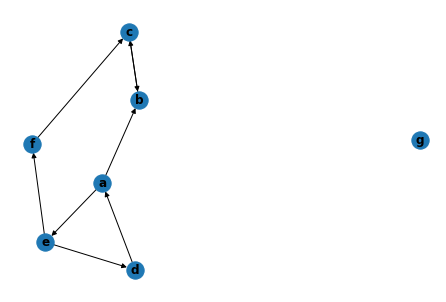

In [26]:
# with networkx
import networkx as nx 
def xGraph(edge_list,node_list):
    Gplot=nx.DiGraph()
    edges=edge_list.collect()
    nodes=node_list.collect()
    for row in edges:
        Gplot.add_edge(row['src'],row['dst'])
    for row in nodes:
        Gplot.add_node(row['id'])
    return Gplot
Gplot=xGraph(g.edges,g.vertices)
nx.draw(Gplot, with_labels=True, font_weight='bold')

In [ ]:
# 